In [193]:
from commonfunctions import *
from pre_processing import *
from staff import calculate_thickness_spacing, remove_staff_lines, coordinator
from segmenter import Segmenter
from connected_componentes import  *
from fit import match, remove_repeated_matches, predict
from symbol import Note
from box import Box
import glob
import cv2
import pickle
from imutils import resize as im_resize
from scipy.ndimage import binary_fill_holes
from skimage.morphology import skeletonize, thin

In [194]:
quarter_templates = ['heads/black/quarter.png', 'heads/black/solid-note.png']
half_templates = ['heads/half/half-note-space.png', 'heads/half/half-space.png', 'heads/half/half.png']
whole_templates = ['heads/whole/whole-note-space.png', 'heads/whole/whole-space.png', 'heads/whole/whole.png']

templates = {
    'quarters': [cv2.imread(temp_path, 0) for temp_path in quarter_templates],
    'halfs': [cv2.imread(temp_path, 0) for temp_path in half_templates],
    'wholes': [cv2.imread(temp_path, 0) for temp_path in whole_templates]
}

img_name = '01'
img_ext = 'PNG'
scanned_path = 'testcases/test-set-scanned/test-cases/'
camera_path = 'testcases/test-set-camera-captured/test-cases/'

In [195]:
label_map = {
    0:{
        0: 'N0'
    },
    1:{
        0:'b2',
        1:'a2'
    },
    2:{
        0:'g2',
        1:'f2'
    },
    3:{
        0:'e2',
        1:'d2'
    },
    4:{
        0:'c2',
        1:'b1'
    },
    5:{
        0:'a1',
        1:'g1'
    },
    6:{
        0:'f1',
        1:'e1'
    },
    7:{
        0:'d1',
        1:'c1'
    }
}

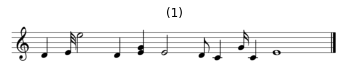

In [196]:
img = io.imread(f'{scanned_path}{img_name}.{img_ext}')
img = gray_img(img)
# img = get_thresholded(img, threshold_otsu(img))
horizontal = IsHorizontal(img)
if horizontal == False:
    theta = deskew(img)
    img = rotation(img,theta)
    img = get_gray(img)
    img = get_thresholded(img, threshold_otsu(img))
    img = get_closer(img)
    horizontal = IsHorizontal(img)
    print(horizontal)
show_images([img])

(212, 1505)


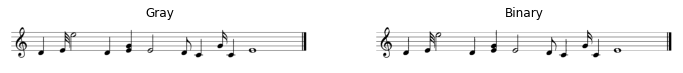

In [197]:
#img = io.imread('testcases/test-set-scanned/test-cases/02.PNG')
print(img.shape)
# if img.shape[1] < 1300:
#     img = resize(img, (img.shape[0], 2000))
# if img.shape[0] > 250:
#     img = resize(img, (250, img.shape[1]))
# print(img.shape)
original = img.copy()
gray = get_gray(img)
bin_img = get_thresholded(gray, threshold_otsu(gray))
show_images([gray, bin_img], ['Gray', 'Binary'])

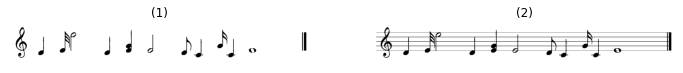

In [198]:
segmenter = Segmenter(bin_img)
imgs_with_staff = segmenter.regions_with_staff
imgs_without_staff = segmenter.regions_without_staff

for i, img in enumerate(imgs_without_staff):
    show_images([img, imgs_with_staff[i]])

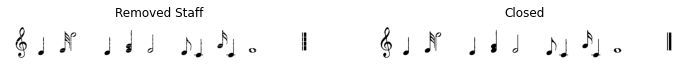

22 20


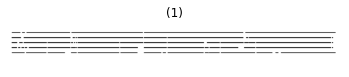

In [199]:
imgs_spacing = []
imgs_rows = []
coord_imgs = []
for i, img in enumerate(imgs_with_staff):
    spacing, rows, no_staff_img = coordinator(img,horizontal)
    imgs_rows.append(rows)
    imgs_spacing.append(spacing)
    coord_imgs.append(no_staff_img)

In [200]:
def estim(c, idx):
    print('estim idx: ', idx)
    spacing = imgs_spacing[idx]
    rows = imgs_rows[idx]
    margin = 1+(spacing/4)
    for index,line in enumerate (rows):
        if c >= line - margin and c <= line + margin:
            return index+1, 0
        elif c >= line + margin and c <= line + 3*margin:
            return index+1, 1
    return 0 , 0 

24
46
68
90
112
134
156


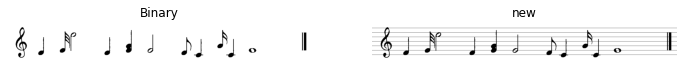

In [201]:
def draw_staff(img,row_positions):
    image = np.copy(img)
    for x in range (len(row_positions)):
        print(int(row_positions[x]))
        image[int(row_positions[x]),:] = 0
    return image

for i, img in enumerate(coord_imgs):
    new_img = draw_staff(img,imgs_rows[i])
    # new_img = otsu(new_img)
    show_images([img,new_img], ['Binary','new'])  

In [202]:
def get_note_name(prev, octave, duration):
    if duration in ['4', 'a_4']:
        return f'{octave[0]}{prev}{octave[1]}/4'
    elif duration in ['8', '8_b_n', '8_b_r', 'a_8']:
        return f'{octave[0]}{prev}{octave[1]}/8'
    elif duration in ['16', '16_b_n', '16_b_r', 'a_16']:
        return f'{octave[0]}{prev}{octave[1]}/16'
    elif duration in ['32', '32_b_n', '32_b_r', 'a_32']:
        return f'{octave[0]}{prev}{octave[1]}/32'
    elif duration in ['2', 'a_2']:
        return f'{octave[0]}{prev}{octave[1]}/2'
    elif duration in ['1', 'a_1']:
        return f'{octave[0]}{prev}{octave[1]}/1'

In [203]:
def filter_beams(prims, prim_with_staff, bounds):
    n_bounds = []
    n_prims = []
    n_prim_with_staff = []
    for i, prim in enumerate(prims):
        if prim.shape[1] >= 2*prim.shape[0]:
            print('filter: ', prim.shape)
            continue
        else:
            n_bounds.append(bounds[i])
            n_prims.append(prims[i])
            n_prim_with_staff.append(prim_with_staff[i])
    return n_prims, n_prim_with_staff, n_bounds

In [204]:
def get_chord_notation(chord_list):
    chord_res = "{"
    for chord_note in chord_list:
        chord_res += (str(chord_note) + ",")
    chord_res = chord_res[:-1]
    chord_res += "}"
    
    return chord_res

1


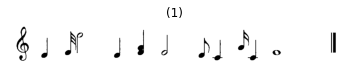

[(21, 43, 171, 98), (70, 154, 158, 182), (41, 260, 146, 311), (47, 313, 137, 341), (70, 481, 158, 509), (35, 587, 146, 615), (57, 694, 147, 722), (70, 861, 158, 910), (79, 923, 169, 968), (35, 1038, 124, 1087), (79, 1082, 169, 1127), (124, 1193, 146, 1231), (47, 1455, 135, 1460), (47, 1464, 135, 1477)]


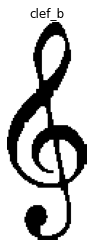

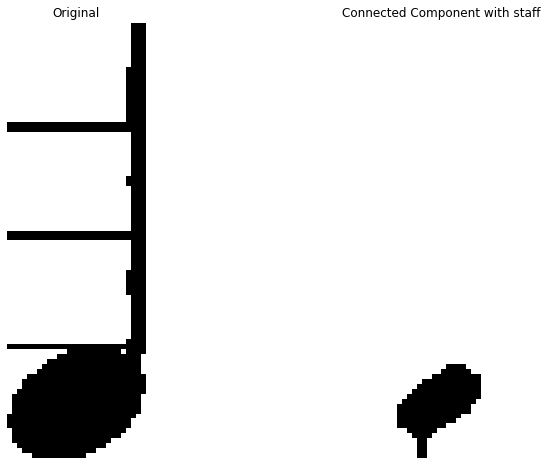

estim idx:  0
161.5
d1


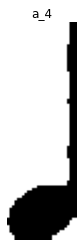

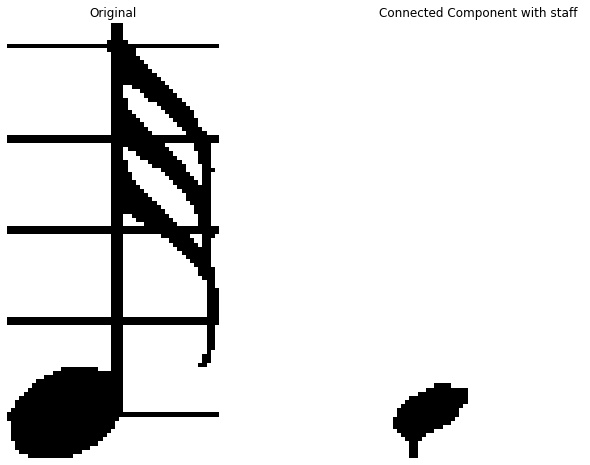

estim idx:  0
149.5
e1


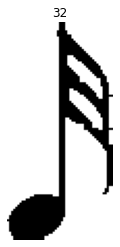

estim idx:  0
68
e2


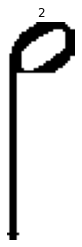

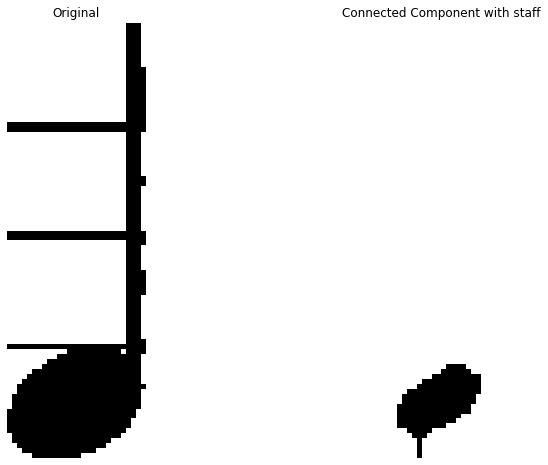

estim idx:  0
161.5
d1


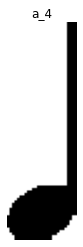

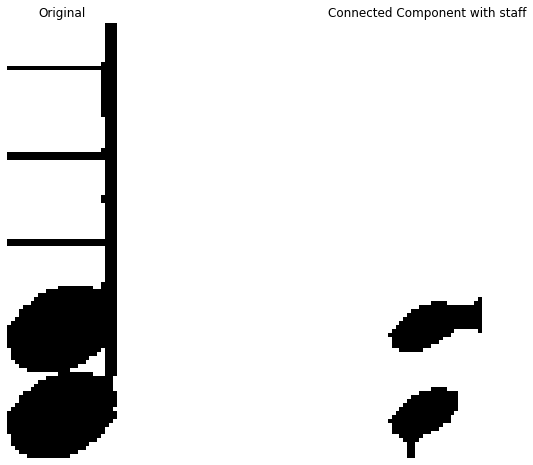

Bound
estim idx:  0
IF COND 27.0 25.0
estim idx:  0
Bound
estim idx:  0


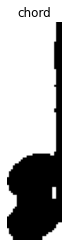

estim idx:  0
147
e1


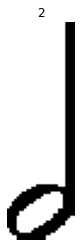

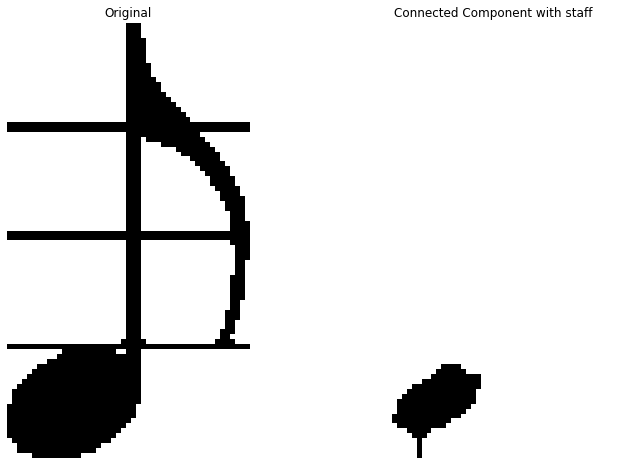

estim idx:  0
161.5
d1


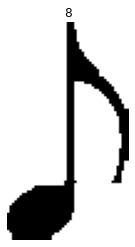

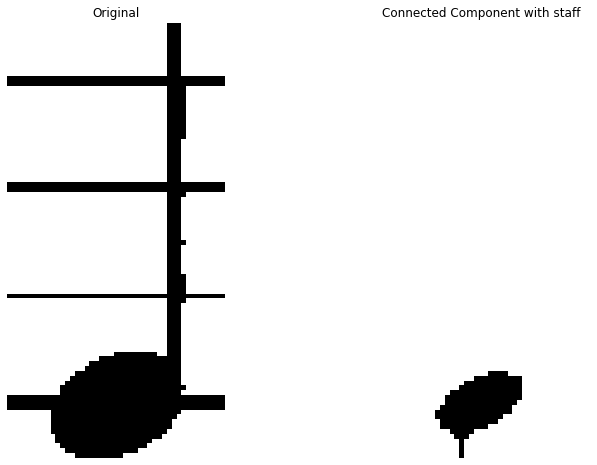

estim idx:  0
172.5
c1


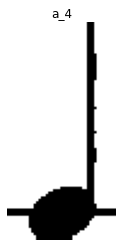

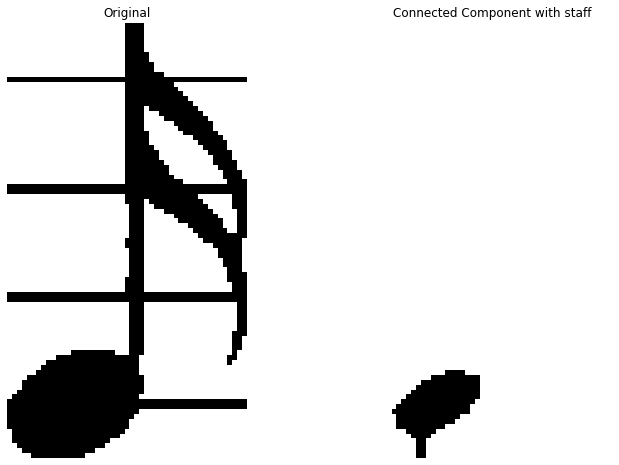

estim idx:  0
127.5
g1


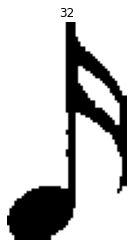

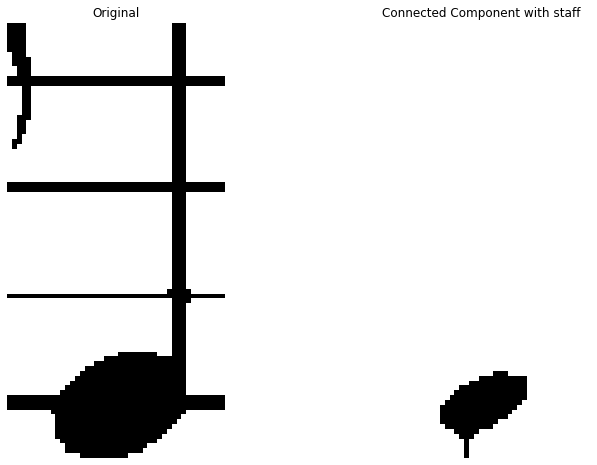

estim idx:  0
172.5
c1


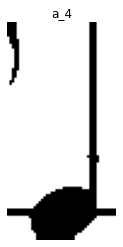

estim idx:  0
146
e1


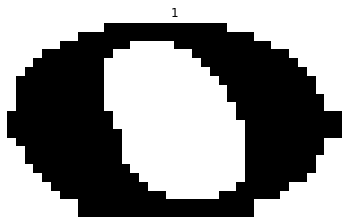

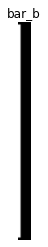

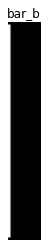

['d1/4', 'e1/32', 'e2/2', 'd1/4', ['e1/4', 'f1', 'g1/4'], 'e1/2', 'd1/8', 'c1/4', 'g1/32', 'c1/4']


In [206]:
black_names = ['4', '8', '8_b_n', '8_b_r', '16', '16_b_n', '16_b_r', '32', '32_b_n', '32_b_r', 'a_4', 'a_8', 'a_16', 'a_32', 'chord']
ring_names = ['2', 'a_2']
whole_names = ['1', 'a_1']
disk_size = segmenter.most_common / 4
out_file = open(f'output/{img_name}.txt', "a")
if len(coord_imgs) > 1:
    out_file.write("{\n")
print(len(coord_imgs))
for i, img in enumerate(coord_imgs):
    show_images([img])
    res = []
    prev = ''
    time_name = ''
    primitives, prim_with_staff, boundary = get_connected_components(img, imgs_with_staff[i])
    print(boundary)  
    for j, prim in enumerate(primitives):
        prim = binary_opening(prim, square(segmenter.most_common-imgs_spacing[i]))
        saved_img = (255*(1 - prim)).astype(np.uint8)
        labels = predict(saved_img)
        octave = None
        label = labels[0]
        if label in black_names:
            test_img = np.copy(prim_with_staff[j])
            test_img = binary_dilation(test_img, disk(disk_size))
            show_images([prim_with_staff[j], test_img], ['Original', 'Connected Component with staff'])
            comps, comp_w_staff, bounds = get_connected_components(test_img, prim_with_staff[j])
            comps, comp_w_staff, bounds = filter_beams(comps, comp_w_staff, bounds)
            bounds = [np.array(bound)+disk_size-2 for bound in bounds]

            if len(bounds) > 1 and label not in ['8_b_n', '8_b_r', '16_b_n', '16_b_r', '32_b_n', '32_b_r']:
                l_res = []
                bounds = sorted(bounds, key= lambda b : -b[2])
                for k in range(len(bounds)):
                    print("Bound")
                    idx, p = estim(boundary[j][0]+bounds[k][2], i)
                    l_res.append(f'{label_map[idx][p]}/4')
                    if k+1 < len(bounds) and (bounds[k][2]-bounds[k+1][2]) > 1.25*imgs_spacing[i]:
                        print("IF COND", bounds[k][2]-bounds[k+1][2], 1.25*imgs_spacing[i])
                        idx, p = estim(boundary[j][0]+bounds[k][2]-imgs_spacing[i]/2, i)
                        l_res.append(f'{label_map[idx][p]}/4')
                res.append(sorted(l_res))
            else:
                # head_img = binary_closing(prim, disk(disk_size))
                # comps, comp_w_staff, bounds = get_connected_components(head_img, prim_with_staff[j])
                # show_images([head_img], ['Connected Component without staff'])
                for bbox in bounds:
                    c = bbox[2]+boundary[j][0]
                    line_idx, p = estim(int(c), i)
                    l = label_map[line_idx][p]
                    res.append(get_note_name(prev, l, label))
                    print(c)
                    print(l)
        elif label in ring_names:
            head_img = 1-binary_fill_holes(1-prim)
            head_img = binary_closing(head_img, disk(disk_size))
            comps, comp_w_staff, bounds = get_connected_components(head_img, prim_with_staff[j])
            for bbox in bounds:
                c = bbox[2]+boundary[j][0]
                line_idx, p = estim(int(c), i)
                l = label_map[line_idx][p]
                res.append(get_note_name(prev, l, label))
                print(c)
                print(l)
        elif label in whole_names:
            c = boundary[j][2]
            line_idx, p = estim(int(c), i)
            l = label_map[line_idx][p]
            print(c)
            print(l)
        elif label in ['bar', 'bar_b', 'clef', 'clef_b', 'natural', 'natural_b'] or label in []:
            show_images([prim], [label])
            continue
        elif label in ['#', '#_b']:
            prev = '#'
        elif label in ['cross']:
            prev = '##'
        elif label in ['flat', 'flat_b']:
            prev = '&'
        elif label in ['dot', 'dot_b', 'p']:
            if len(res) == 0 or (len(res) > 0 and res[-1] in ['flat', 'flat_b', 'cross', '#', '#_b', 't24', 't24_b', 't44', 't44_b']):
                continue
            res[-1] += '.'
        elif label in ['t2', 't4']:
            time_name += label[1]
        elif label in ['t24', 't24_b', 't44', 't44_b']:
            time_name = label[1]+label[2]
        elif label == 'chord':
            print('Chord')
            img = thin(1-prim.copy(), max_iter=20)
            # show_images([img, skeletonize(1-img)])
            head_img = binary_closing(1-img, disk(disk_size))
            # show_images([head_img])
        if label not in ['flat', 'flat_b', 'cross', '#', '#_b']:
            prev = ''
        io.imsave(f'testresult/{i}_{j}.png', saved_img)
        show_images([prim], [label])
    if len(time_name) == 2:
        # "\\" + "meter<\"" + str(time_name[0]) + "/" + str(time_name[1])+"\">"
        # print()
        out_file.write("[ " + "\\" + "meter<\"" + str(time_name[0]) + "/" + str(time_name[1])+"\">" + ' '.join([str(elem) if type(elem) != list else get_chord_notation(elem) for elem in res])  + "]\n")
        res = ["\\" + "meter<\"" + str(time_name[0]) + "/" + str(time_name[1])+"\">"] + res
    print(res) 
if len(coord_imgs):
    out_file.write("}")
out_file.close()